<a href="https://colab.research.google.com/github/SamuelXJames/DenoisingAutencoder/blob/master/CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wait for 8 seconds...
TensorBoard link:
http://e301457b.ngrok.io
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 200, 32)           128       
_________________________________________________________________
activation_44 (Activation)   (None, 200, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 32)           128       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 100, 32)           0         
_________________________________________________________________
activation_45 (Activation)   (None, 100, 32)           0         
_________________________________________________________________
conv1d_45 (

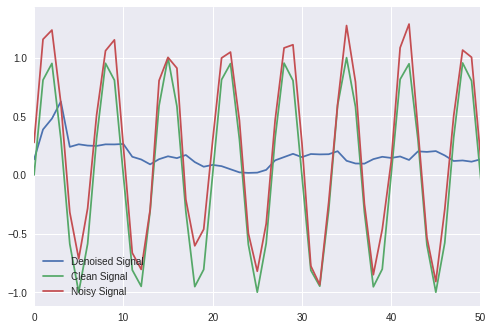

In [9]:
!pip install pydrive
!pip install talos
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import *
import pydrive
from keras.layers import Dense,Conv1D,RepeatVector,TimeDistributed,Input
from keras.layers import Conv1D,MaxPooling1D,UpSampling1D
from keras.layers import Activation,BatchNormalization
from keras.models import Model,Sequential
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


#Authenticate/Create PyDrive client 
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)




tbc=TensorBoardColab()
batch_size = 1000


def create_data():
  length = 1
  dt = 0.005
  noise_factor = 0.35
  data = []
  data_noisy = []
  for i in range(batch_size):
      freq = 30*np.random.random() + 1
      t = np.arange(0,length,dt)
      #signal = np.arange(-0.5*length,0.5*length,dt)
      signal = np.sin(2*np.pi*freq*t)
      noisy_signal = signal+noise_factor*np.random.rand(len(t))
      data.append(signal)
      data_noisy.append(noisy_signal)
  data = np.array(data)
  data_noisy = np.array(data_noisy)
  return data, data_noisy
#Create Test/Train Data
signal,signal_noisy = create_data()

#Scale Data - Need a better scaler than MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data  = np.vstack((signal,signal_noisy))
data = scaler.fit_transform(data)
signal = data[0:batch_size][:]
signal_noisy = data[batch_size:2*batch_size][:]

#Prediction Data
x_pred = signal_noisy[0][:]
#Pre Autoencoder
x_pred_pre = signal_noisy[0] 
x_pred_pre = x_pred_pre.reshape((-1,len(x_pred_pre)))
x_pred_pre = scaler.inverse_transform(x_pred_pre)
#Clean
clean_signal = signal[0][:]
clean_signal = clean_signal.reshape((-1,len(clean_signal)))
clean_signal = scaler.inverse_transform(clean_signal)

#Input Shaping
features = 1
timesteps = len(signal[0])
shape = (batch_size,timesteps,features)
#Input shape should equal [samples, timesteps, features]
x = signal.reshape(shape)
y = signal_noisy.reshape(shape)
#x_pred = x_pred.reshape(1,timesteps,features)


#A custom loss function may work better than some 
#of the loss functionss provided by Keras
#Here is a loss function from Hvass Labs that
#invokes a warmup period
warmup_steps = 10
def loss_mse_warmup(y_true, y_pred):
    

    
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

#For Optimization
def create_autoencoder(inputs,max_filters,min_filters,layers):
  encoded = inputs
  encoded_filter_range = np.linspace(max_filters,min_filters,layers)
  for num_filters in encoded_filter_range: 
    encoded = Conv1D(num_filters,3,padding = 'same')(encoded)
  
    if(num_filters==max_filters):
      encoded = BatchNormalization()(encoded)
  
    encoded = Activation('relu')(encoded)
    encoded = MaxPooling1D(2,padding = 'same')(encoded)
  
  decoded_filter_range = np.linspace(min_filters,max_filters,layers)
  for num_filters in decoded_filter_range: 
    encoded = Conv1D(num_filters,3,padding = 'same')(encoded)
  
    encoded = Activation('relu')(encoded)
    encoded = UpSampling1D(2)(encoded)
    
  decoded = Conv1D(1,3,activation = 'sigmoid',padding = 'same')(encoded)
  
  autoencoder = Model(inputs,decoded)
  
  return autoencoder


#NOT THE OPTIMIZED MODEL
def create_Conv1D():
  inputs = Input(shape = (timesteps,features))
  
  encoded = Conv1D(32,3, padding = 'same')(inputs)
  encoded = BatchNormalization()(encoded)
  encoded = Activation('relu')(encoded)
  encoded = MaxPooling1D(2,padding = 'same')(encoded)
  
  
  encoded = Conv1D(16,3,padding = 'same')(encoded)
  encoded = Activation('relu')(encoded)
  encoded = MaxPooling1D(2,padding = 'same')(encoded)
  
  encoded = Conv1D(8,3, padding = 'same')(encoded)
  encoded = Activation('relu')(encoded)
  encoded = MaxPooling1D(2,padding = 'same')(encoded)
  
  
  decoded = Conv1D(8,3,padding = 'same')(encoded)
  decoded = Activation('relu')(decoded)
  decoded = UpSampling1D(2)(decoded)
  
  decoded = Conv1D(16,3, padding = 'same')(decoded)
  decoded = Activation('relu')(decoded)
  decoded = UpSampling1D(2)(decoded)
  
  decoded = Conv1D(32,3,padding = 'same')(decoded)
  decoded = Activation('relu')(decoded)
  decoded = UpSampling1D(2)(decoded)
  
  decoded = Conv1D(1,3,activation = 'sigmoid',padding = 'same')(decoded)
  
  autoencoder = Model(inputs,decoded)
  
  return autoencoder





def nn_predict(model,prediction_data):
  pad_length = timesteps-(np.size(prediction_data)%timesteps)
  if pad_length != timesteps:
    prediction_data = np.pad(prediction_data,[(0,0),(0,pad_length)],
                             mode = 'constant', constant_values = 0)
   
  prediction_data = prediction_data.reshape((-1,timesteps))
  
  predicted_data = []
  
  for i in range(np.size(prediction_data,0)):
    pred_part = prediction_data[i].reshape(1,timesteps,features) 
    pred_part = model.predict(pred_part)
    predicted_data.append(pred_part)
  
  predicted_data = (np.array(predicted_data)).flatten()
  
  predicted_data = predicted_data.reshape(-1,len(predicted_data))
  predicted_data = scaler.inverse_transform(predicted_data)
  return predicted_data



#NN HyperParameters
epochs = 100
optimizer = RMSprop(lr=1e-3)


#NN Fitting
autoencoder = create_Conv1D()
autoencoder.compile(optimizer = optimizer, loss = 'mse')
autoencoder.summary()

autoencoder.fit(y,x,epochs=epochs,
                callbacks=[TensorBoardColabCallback(tbc)])



#Prediction Data
prediction = nn_predict(autoencoder,x_pred).flatten()

         
#Plot Prediction                                   
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(prediction,label = 'Denoised Signal')
ax.plot(clean_signal.flatten(), label = 'Clean Signal')
ax.plot(x_pred_pre.flatten(), label = 'Noisy Signal')
plt.xlim(0,50)
ax.legend(loc = 3)
  
  
#Save Model to Google Drive
# autoencoder.save('model.h5', include_optimizer=False)
# model_file = drive.CreateFile({'title' : 'A_new.h5'})
# model_file.SetContentFile('model.h5')
# model_file.Upload()
# drive.CreateFile({'id': model_file.get('id')})
  
  
  
  
  
  